In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## DATA PREPARATION 

In [35]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ENDB2/SESSION-06/tweets.csv')
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [36]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

In [37]:
# Import Library
import random
import torch, torchtext
# from torchtext import data 
from torchtext.legacy import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [38]:
# FIELD
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True, init_token='<sos>', eos_token='<eos>')
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [39]:
fields = [('tweets', Tweet),('labels',Label)]

In [40]:
example = [data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [41]:
twitterDataset = data.Dataset(example, fields)

In [42]:
(train, valid) = twitterDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [43]:
(len(train), len(valid))

(1159, 205)

In [44]:
# SEE EXAAMPLES

In [45]:
vars(train.examples[10])

{'labels': 0,
 'tweets': ['Obama',
  ',',
  'Romney',
  'agree',
  ':',
  'Admit',
  'women',
  'to',
  'Augusta',
  'golf',
  'club',
  ':',
  'US',
  'President',
  'Barack',
  'Obama',
  'believes',
  'women',
  'should',
  'be',
  'allowe',
  '...',
  'http://t.co/PVKrepqI']}

In [46]:
vars(valid.examples[10])

{'labels': 0,
 'tweets': ['@Fake_Dispatch',
  'no',
  'way',
  ',',
  'obama',
  'would',
  'school',
  'his',
  'ass',
  '!',
  'santorum',
  'has',
  'weak',
  'arms',
  '!',
  'lmao']}

In [47]:
Tweet.build_vocab(train)
Label.build_vocab(train)

In [48]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4653
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [51]:
import os, pickle
import pdb
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## MODEL

### ENCODER

In [52]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
         # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)

        
        
        
        
    def forward(self, src, srcLength):
        
        #src = [src len, batch size]
        # import pdb
        # pdb.set_trace()
        embedded = self.embedding(src)

        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.encoder(embedded)

        #outputs = [batch size, src len,  hid dim * n directions]
        #hidden = [ n layers * n directions, batch size, hid dim]
        hidden_output = hidden.permute(1, 0, 2)
        #[batch_size, num_layers, hid_dim]

        #print(f"Encoder output : {outputs.shape}, Encoder hidden shape : {hidden.shape}")        
        return hidden_output

### DECODER

In [53]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()

        
         # LSTM layer
        self.decoder = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
        
    def forward(self, src):
        
        outputs, (hidden, cell) = self.decoder(src)

        #outputs = [batch size, src len,  hid dim * n directions]
        #hidden = [batch size, n layers * n directions,  hid dim]

        dense_outputs = self.fc(hidden[0])
        #print(f"Decoder output : {outputs.shape}, Decoder hidden shape :{hidden.shape}")
        return dense_outputs

### ENCODER DECODER

In [54]:
class EncoderDecoderModel(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src, src_length):

    encoder_output = self.encoder(src, src_length)
    # pdb.set_trace()
    decoder_output = self.decoder(encoder_output)
                          
    return decoder_output

### PARAMS

In [55]:
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = len(Label.vocab)
num_layers =1
dropout = 0.2
dec_input_nodes = num_hidden_nodes


enc = Encoder(size_of_vocab, embedding_dim, num_hidden_nodes, num_layers, dropout)
dec = Decoder(dec_input_nodes, num_hidden_nodes, num_output_nodes, num_layers, dropout)

model = EncoderDecoderModel(enc, dec)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [56]:
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


EncoderDecoderModel(
  (encoder): Encoder(
    (embedding): Embedding(4653, 300)
    (encoder): LSTM(300, 100, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (decoder): LSTM(100, 100, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=100, out_features=3, bias=True)
  )
)
The model has 1,637,803 trainable parameters


In [57]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

## TRAIN

In [58]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [59]:

## EVALUATE

In [60]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [61]:
## TRAIN AND EVALUATE


In [62]:
N_EPOCHS = 50
best_valid_loss = float('inf')

train_loss_epoch=[]
valid_loss_epoch=[]
train_acc_epoch=[]
valid_acc_epoch=[]


for epoch in range(N_EPOCHS):

     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)
    train_acc_epoch.append(train_acc)
    valid_acc_epoch.append(valid_acc)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.000 | Train Acc: 65.78%
	 Val. Loss: 0.908 |  Val. Acc: 68.30% 

	Train Loss: 0.840 | Train Acc: 69.12%
	 Val. Loss: 0.799 |  Val. Acc: 68.30% 

	Train Loss: 0.763 | Train Acc: 69.12%
	 Val. Loss: 0.785 |  Val. Acc: 68.30% 

	Train Loss: 0.738 | Train Acc: 69.12%
	 Val. Loss: 0.778 |  Val. Acc: 68.30% 

	Train Loss: 0.709 | Train Acc: 70.22%
	 Val. Loss: 0.769 |  Val. Acc: 68.30% 

	Train Loss: 0.649 | Train Acc: 75.00%
	 Val. Loss: 0.668 |  Val. Acc: 74.55% 

	Train Loss: 0.570 | Train Acc: 80.41%
	 Val. Loss: 0.694 |  Val. Acc: 75.00% 

	Train Loss: 0.470 | Train Acc: 84.04%
	 Val. Loss: 0.683 |  Val. Acc: 77.68% 

	Train Loss: 0.380 | Train Acc: 88.18%
	 Val. Loss: 0.711 |  Val. Acc: 79.46% 

	Train Loss: 0.301 | Train Acc: 90.88%
	 Val. Loss: 0.797 |  Val. Acc: 79.02% 

	Train Loss: 0.238 | Train Acc: 92.82%
	 Val. Loss: 0.796 |  Val. Acc: 82.14% 

	Train Loss: 0.217 | Train Acc: 92.99%
	 Val. Loss: 0.802 |  Val. Acc: 78.57% 

	Train Loss: 0.180 | Train Acc: 93.50%
	

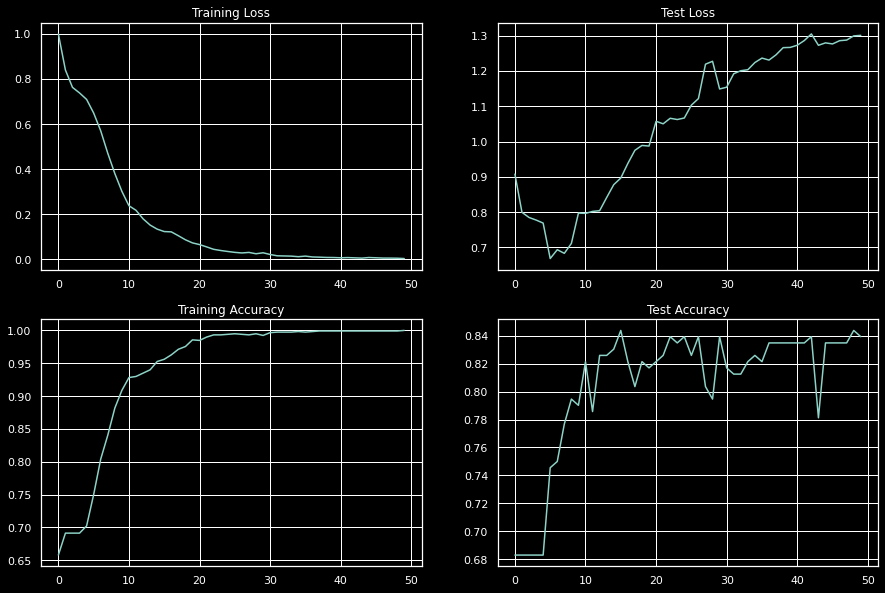

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(valid_loss_epoch)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy")
axs[1, 1].plot(valid_acc_epoch)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [64]:
## MODEL TESTING 

In [65]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [66]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Positive'